In [3]:
# base 
import os 
import sys
from src import helpers, config, plotting, evaluation
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle
import logging
from pathlib import Path
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional, Iterable, Hashable, Type

# base
from sklearn.base import TransformerMixin

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# models
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer

# ignore warnings 
import warnings 
warnings.filterwarnings('ignore')

from sklearn import set_config
set_config(display='diagram')


# yet to arrange
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
# set the target column
%matplotlib inline 

sns.set_style('white')
sns.set_palette('deep')
mpl.rcParams['figure.figsize'] = config.DEFAULT_FIGSIZE
mpl.rcParams['lines.linewidth'] = config.DEFAULT_PLOT_LINEWIDTH
mpl.rcParams['lines.linestyle'] = config.DEFAULT_PLOT_LINESTYLE
mpl.rcParams['font.size'] = config.DEFAULT_AXIS_FONT_SIZE

df = pd.read_parquet(config.INT_FILE_PATH / config.INT_FILE_NAME)


In [44]:
df.income.describe()

count    139520.000000
mean       6957.338876
std        6496.586382
min           0.000000
25%        3720.000000
50%        5760.000000
75%        8520.000000
max      578580.000000
Name: income, dtype: float64

In [21]:
df.drop(
    columns=[
        "id",
        "year",
        "interest_rate_spread",
        "rate_of_interest",
        "upfront_charges",
        "secured_by",
        "construction_type",
        "security_type",
    ],
    inplace=True,
)


    NUMBER OF MISSING COLUMNS: 68415
    MISSING COLUMNS (0: NO MISSING VALUES, 1: MISSING VALUES) 
    loan_limit                    3344
gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
credit_worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
term                            41
neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
occupancy_type                   0
total_units                      0
income                        9150
credit_type                      0
credit_score                     0
co_applicant_credit_type         0
age                            200
submission_of_application      200
ltv                          15098
region                           0
status                           0
dtir1               

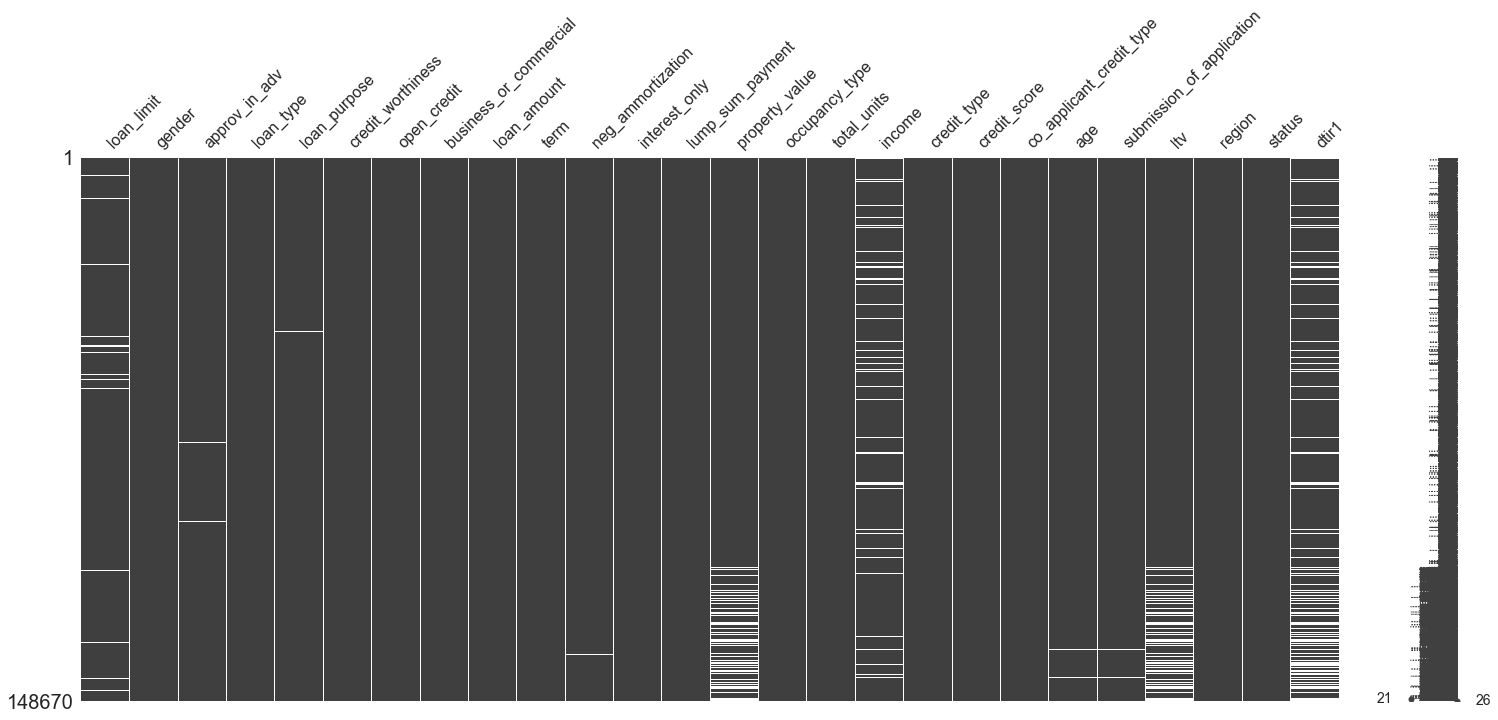

MISSINGNESS CORRELATIONS


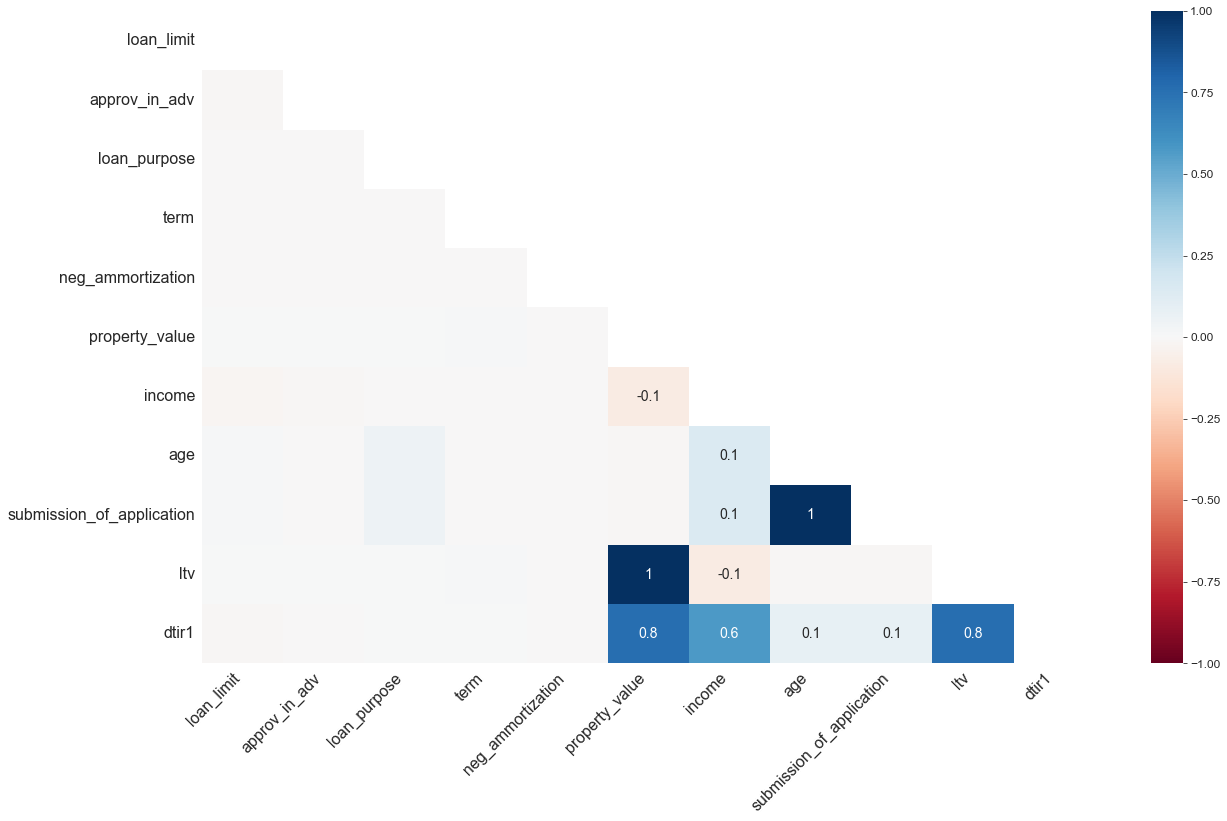

In [14]:
helpers.missingness_checks(df.sort_values(by='status'))

In [15]:
df_dropped = df.dropna(axis=0, how='any', subset=['approv_in_adv', 'loan_purpose', 'term', 'neg_ammortization', 'age', 'submission_of_application']) 

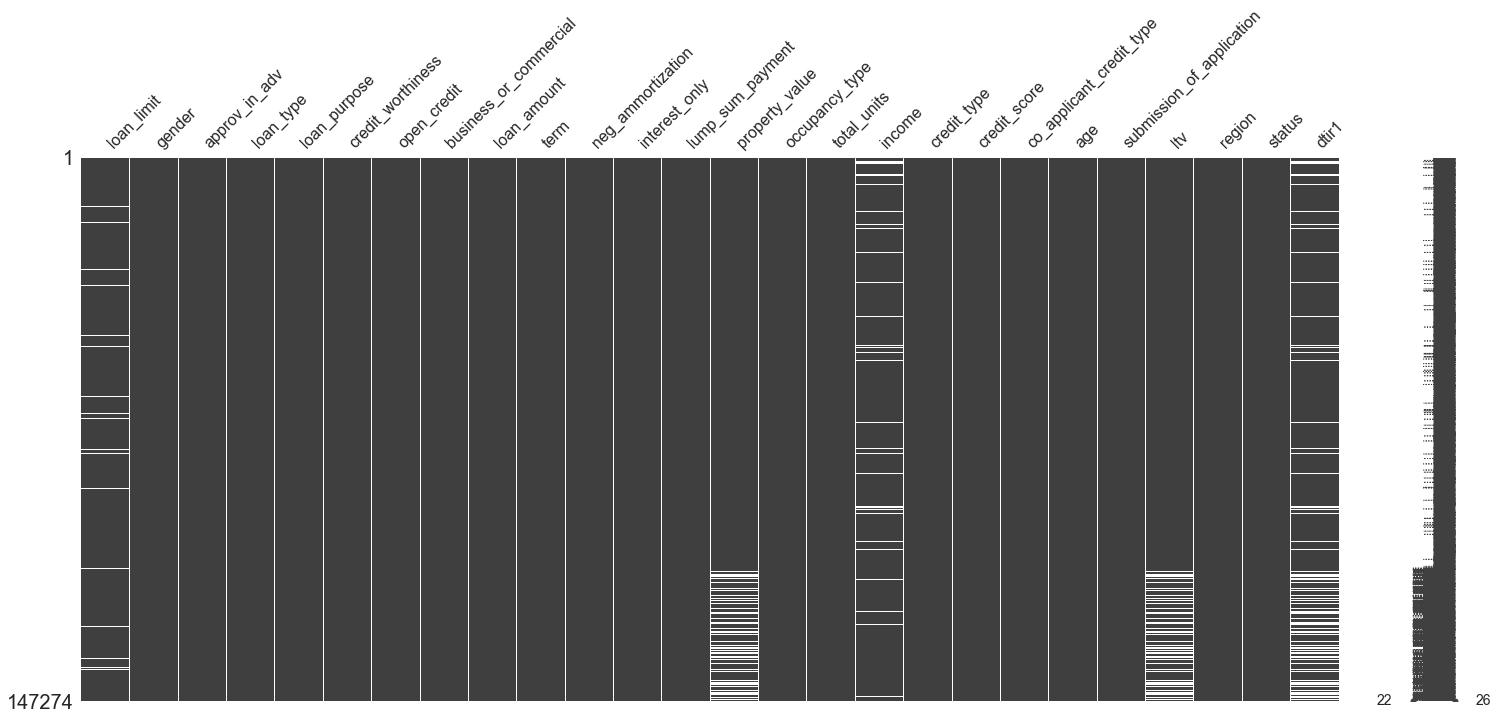

In [109]:
msno.matrix(df_dropped.sort_values('status'))
plt.show()

In [22]:
# pd.crosstab(index=df.loan_type, columns=df.loan_purpose, normalize='index')

In [96]:
df.loc[df['loan_purpose'].isna(), 'loan_type'].value_counts()

t1    94
t2    30
t3    10
Name: loan_type, dtype: int64

In [47]:
num_cols = helpers.get_numeric_columns(df)

In [48]:
# df_test = df[num_cols]
# df_test

,loan_limit,approv_in_adv,credit_worthiness,open_credit,business_or_commercial,loan_amount,term,neg_ammortization,interest_only,lump_sum_payment,property_value,income,credit_score,submission_of_application,ltv,status,dtir1
0,1.0,0.0,1,0,0,116500,360.0,0.0,0,0,118000.0,1740.0,758,1.0,98.728814,1,45.0
1,1.0,0.0,1,0,1,206500,360.0,0.0,0,1,NaN,4980.0,552,1.0,NaN,1,NaN
2,1.0,1.0,1,0,0,406500,360.0,1.0,0,0,508000.0,9480.0,834,1.0,80.019685,0,46.0
3,1.0,0.0,1,0,0,456500,360.0,0.0,0,0,658000.0,11880.0,587,0.0,69.376900,0,42.0
4,1.0,1.0,1,0,0,696500,360.0,0.0,0,0,758000.0,10440.0,602,0.0,91.886544,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,1.0,0.0,1,0,0,436500,180.0,0.0,0,0,608000.0,7860.0,659,1.0,71.792763,0,48.0
148666,1.0,0.0,1,0,0,586500,360.0,0.0,0,0,788000.0,7140.0,569,0.0,74.428934,0,15.0
148667,1.0,0.0,1,0,0,446500,180.0,0.0,0,0,728000.0,6900.0,702,0.0,61.332418,0,49.0
148668,1.0,0.0,1,0,0,196500,180.0,0.0,0,0,278000.0,7140.0,737,1.0,70.683453,0,29.0


In [28]:
df_income = df_dropped.loc[:, ['credit_score', 'interest_only', 
'loan_purpose', 'loan_type', 'income']]

In [29]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147274 entries, 0 to 148669
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   credit_score   147274 non-null  int64   
 1   interest_only  147274 non-null  int64   
 2   loan_purpose   147274 non-null  category
 3   loan_type      147274 non-null  category
 4   income         138356 non-null  float64 
dtypes: category(2), float64(1), int64(2)
memory usage: 4.8 MB


In [35]:
df_income_vectorized = df_income.loc[:, ['income', 'credit_score', 'interest_only']]
for col in ['loan_purpose', 'loan_type']:
    dummies = pd.get_dummies(df_income[col],  prefix=col, prefix_sep='_', drop_first=True)
    df_income_vectorized = pd.concat([df_income_vectorized, dummies], axis=1)

In [37]:
df_income_vectorized_columns = df_income_vectorized.columns

In [38]:
# using df_dropped for income

from sklearn.impute import KNNImputer

knn_imp = KNNImputer()

df_income_vectorized = knn_imp.fit_transform(df_income_vectorized)

In [40]:
df_fin = pd.DataFrame(df_income_vectorized, columns=df_income_vectorized_columns)

In [42]:
df_fin.income.describe()

count    147274.000000
mean       6867.591591
std        6337.802404
min           0.000000
25%        3720.000000
50%        5700.000000
75%        8400.000000
max      578580.000000
Name: income, dtype: float64

In [58]:
df_final['loan_limit'].value_counts()

1.0    137881
0.0      9984
0.8       630
0.6       141
0.4        27
0.2         7
Name: loan_limit, dtype: int64

<AxesSubplot:>

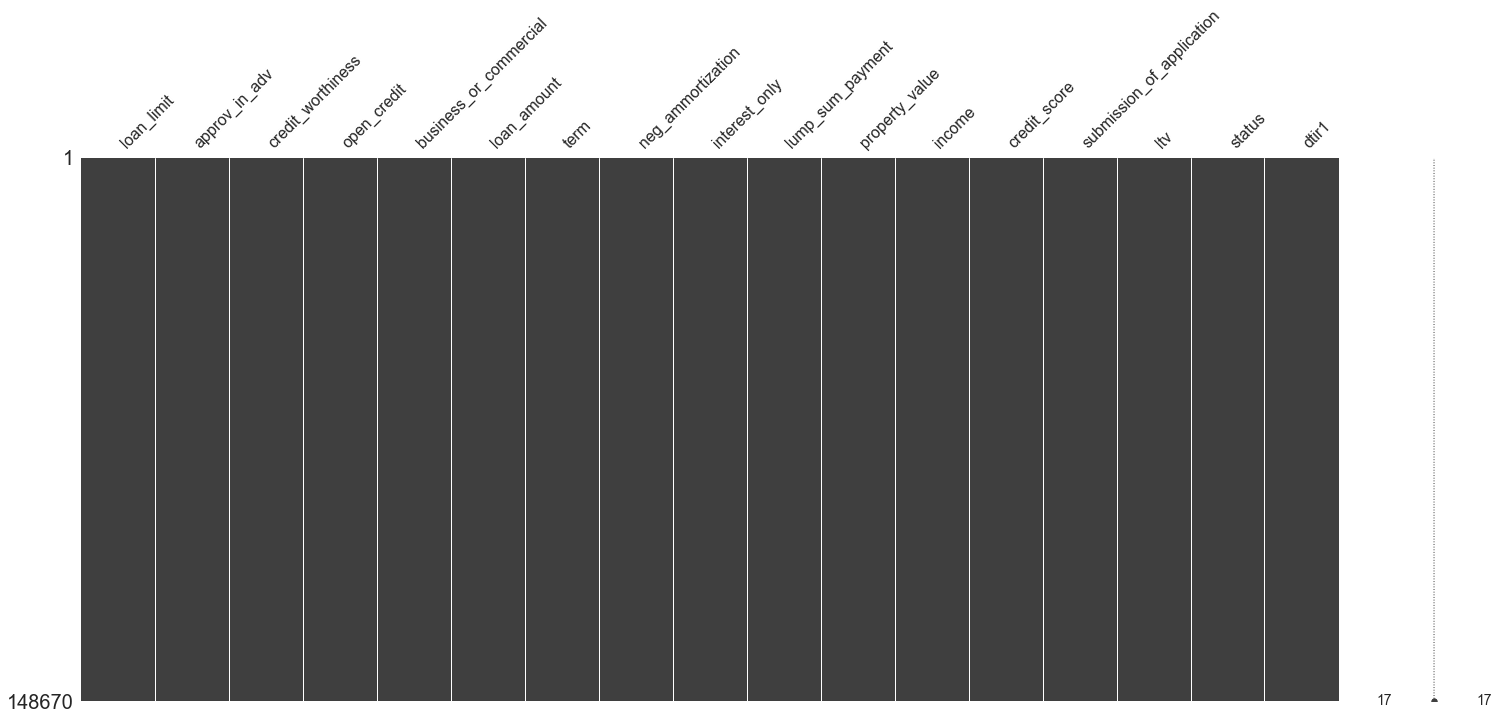

In [57]:
msno.matrix(pd.DataFrame(df_final))


In [ ]:
helpers.return_value_counts(df_final)